# LSTM with Keras

In practice, there are some [problems with training RNN](https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47), and most applications use a variation called [LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

Let's use an LSTM network to [predict word completions](http://curiousily.com/data-science/2017/05/23/tensorflow-for-hackers-part-5.html) for [Jonathan Swift](https://en.wikipedia.org/wiki/Jonathan_Swift), the author of Gulliver's Travels.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
try:
    import keras
except ModuleNotFoundError:
    from tensorflow import keras
print('GPU:', tf.test.is_gpu_available())

GPU: True


The data is at `../data/Gulliver.txt` and contains the Project Gutenberg's version of the book.

In [5]:
filename = '../data/Gulliver.txt'
text = open(filename, 'rt').read()
text = text[352:]
print("Number of characters: {}".format(len(text)))
print("Number of unique characters: {}".format(len(set(text))))
print("Number of lines: {}".format(text.count('\n')))
print("Number of words: {}".format(text.count(' ')))
print()
print("Excerpt:")
print("*" * len("Excerpt:"))
print(text[:300])

Number of characters: 308221
Number of unique characters: 85
Number of lines: 5586
Number of words: 51438

Excerpt:
********
Title: Gulliver's Travels
       Into Several Remote Regions of the World


Author: Jonathan Swift

Editor: Thomas M. Balliet

Release Date: November 26, 2005  [eBook #17157]

Language: English

Character set encoding: ISO-646-US (US-ASCII)


***START OF THE PROJECT GUTENBERG EBOOK GULLIVER'S TRAVEL


We create mappings from characters to integers and from integers to characters:

In [6]:
chars = list(set(text))
data_size, vocab_size = len(text), len(chars)

id_to_char = dict(enumerate(chars)) # { i: ch for i,ch in enumerate(chars) }
char_to_id = dict(zip(id_to_char.values(), id_to_char.keys())) # { ch: i for i,ch in enumerate(chars) }
data = np.array([char_to_id[c] for c in text], dtype=int)

We'll use sequences of length 40 and with a step size of 3 so that we don't have complete overlap.

The following generates `X` and `Y`.

In [7]:
seq_length = 40
step = 3
sequences = []
next_chars = []
for i in range(0, len(text) - seq_length, step):
    sequences.append(text[i: i + seq_length])
    next_chars.append(text[i + seq_length])
n_sequences = len(sequences)
print('# sequences:', n_sequences)
print(sequences[0], '->', next_chars[0])

X = np.zeros((n_sequences, seq_length, vocab_size), dtype=np.bool)
Y = np.zeros((n_sequences, vocab_size), dtype=np.bool)

for i, seq in enumerate(sequences):
    for t, char in enumerate(seq):
        X[i, t, char_to_id[char]] = 1
    Y[i, char_to_id[next_chars[i]]] = 1

# sequences: 102727
Title: Gulliver's Travels
       Into Se -> v


**Create the model using Keras**.
Use one or more LSTM layers and consider what is the correct output layer.
Note that the input to an LSTM layer is a sequence, so if you connect two LSTM layers you need the earlier one to return a sequence -- there's a special argument for that in the LSTM constructor.

In [235]:
layers = [
    keras.layers.LSTM(128, return_sequences=True, input_shape=(None, vocab_size)),
    keras.layers.LSTM(32),
    keras.layers.Dense(vocab_size, activation='softmax')
]
model = keras.models.Sequential(layers)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, None, 128)         109568    
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                20608     
_________________________________________________________________
dense_6 (Dense)              (None, 85)                2805      
Total params: 132,981
Trainable params: 132,981
Non-trainable params: 0
_________________________________________________________________


**Compile the model.**

In [236]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(), 
    metrics=['accuracy']
)

To measure accuracy on a test set, we tell Keras to split of the data for a train and test set.

Other training parameters are the batch size - number of samples or sequences per gradient update - and epochs - number of times we want to iterate over the entire data.

**Choose the training parameters and run the training**. This may take about 30-60 secons per epoch.

In [237]:
test_size = 0.05
batch_size = 128
epochs = 50

history = model.fit(
    X, Y, 
    validation_split=test_size, 
    batch_size=batch_size, 
    epochs=epochs).history

Train on 97590 samples, validate on 5137 samples
Epoch 1/50
97590/97590 [==============================] - 93s 954us/step - loss: 3.1692 - acc: 0.1665 - val_loss: 3.3205 - val_acc: 0.1468
Epoch 2/50
97590/97590 [==============================] - 89s 911us/step - loss: 2.9687 - acc: 0.2177 - val_loss: 3.1871 - val_acc: 0.2040
Epoch 3/50
97590/97590 [==============================] - 90s 924us/step - loss: 2.6726 - acc: 0.2905 - val_loss: 2.9142 - val_acc: 0.2488
Epoch 4/50
97590/97590 [==============================] - 90s 922us/step - loss: 2.4496 - acc: 0.3212 - val_loss: 2.7644 - val_acc: 0.2768
Epoch 5/50
97590/97590 [==============================] - 92s 945us/step - loss: 2.3249 - acc: 0.3417 - val_loss: 2.6926 - val_acc: 0.2938
Epoch 6/50
97590/97590 [==============================] - 91s 933us/step - loss: 2.2467 - acc: 0.3603 - val_loss: 2.6385 - val_acc: 0.3132
Epoch 7/50
97590/97590 [==============================] - 90s 927us/step - loss: 2.1832 - acc: 0.3736 - val_loss: 2.6

Here we plot the change in accuracy and loss over the training time:

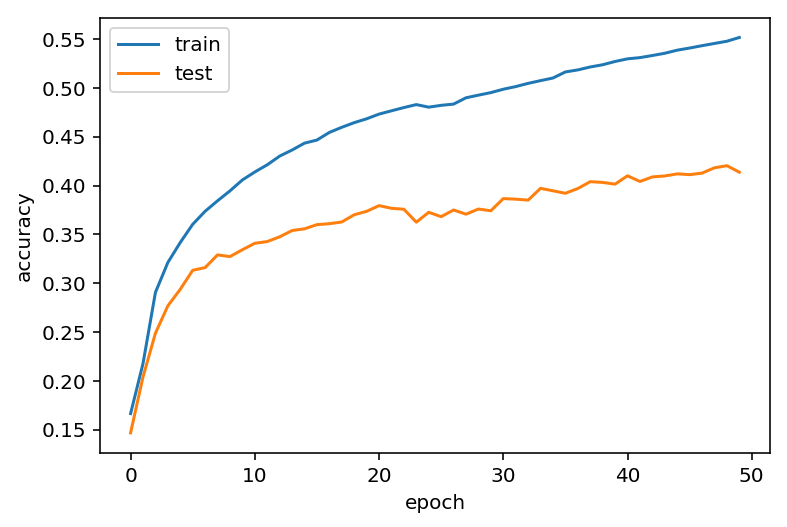

In [242]:
plt.plot(history['acc'], label='train')
plt.plot(history['val_acc'], label='test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();

Now let's apply the model for text completion.

In [330]:
def complete(sentence):
    # one-hot encode
#     x = np.zeros((1, len(sentence), vocab_size), dtype=float)
#     keras.utils.to_categorical()
#     for t, char in enumerate(sentence):
#         x[0, t, char_to_id[char]] = 1
    x = keras.utils.to_categorical([char_to_id[x] for x in sentence], num_classes=vocab_size)
    x = np.expand_dims(x, axis=0)
    completion = ''
    for _ in range(5):
        # predict char distribution
        pred = model.predict(x).squeeze() # returns 2D array
        # sample next char
        char_id = pred.argmax()
        next_char = id_to_char[char_id]
        completion += next_char
        # can't have a completion of a single non-char
        if completion in (' ', '\n', '.', ',', ';'):
            completion = ''
            continue
        # if next char is space/newline, stop completion
        if next_char in (' ', '\n'): 
            break 
        # update x by adding the one-hot vector of the next char
        new_x = np.zeros((1, 1, vocab_size))
        new_x[0, 0, char_id] = 1
        x = np.concatenate((x, new_x), axis=1)
    return completion

In [336]:
sentence = 'Good morning, how are yo'
print(sentence, '...', complete(sentence), sep='')

Good morning, how are yo...u 


In [335]:
sentence = 'Good evening, how are yo'
print(sentence, '...', complete(sentence), sep='')

Good evening, how are yo...u 


In [337]:
sentence = 'How I wish you wer'
print(sentence, '...', complete(sentence), sep='')

How I wish you wer...e 


In [338]:
sentence = 'Would you like some brea'
print(sentence, '...', complete(sentence), sep='')

Would you like some brea...d 


In [348]:
sentence = 'What a wonderful wo'
print(sentence, '...', complete(sentence), sep='')

What a wonderful wo...rds 


# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Data Science with Python_](https://github.com/yoavram/DataSciPy) workshop.

The notebook was written using [Python](http://python.org/) 3.6.5.

This work is licensed under a [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)